In [1]:
import torch
import h5py
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Subset
from collections import Counter

/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def crop_center(img):
    y, x = img.shape[0:2]  # Get the original dimensions of the image
    
    startx = x // 2 - 10
    starty = y // 2 - 10
    
    return img[starty:starty + 21, startx:startx + 21]

In [4]:

# Load the TXT file
labels_df = pd.read_csv('data/0ADD710_gated_full_final.txt', sep='\t')
print(labels_df.shape)

# Filter the DataFrame to include only the two relevant classes
labels_df = labels_df[labels_df['Multiclass_5'].isin(['Monocyte/Macrophages', 'Granulocytes'])]

print(labels_df[0:20].index)

# Analyze class distribution
class_counts = Counter(labels_df['Multiclass_5'])
print("Class distribution after filtering:", class_counts)

# Identify the majority and minority classes
majority_class = max(class_counts, key=class_counts.get)
minority_class_count = class_counts[min(class_counts, key=class_counts.get)]

# Balance the dataset
balanced_df = pd.concat([
    labels_df[labels_df['Multiclass_5'] == majority_class].sample(minority_class_count, random_state=42),
    labels_df[labels_df['Multiclass_5'] != majority_class]
]).sample(frac=1, random_state=42)  # Shuffle the dataset

print(balanced_df[0:20].index)

# Map string labels to integers
label_mapping = {'Monocyte/Macrophages': 1, 'Granulocytes': 0}
labels_int = balanced_df['Multiclass_5'].map(label_mapping).values
print("Balanced labels shape:", labels_int.shape)

# Open the HDF5 file
with h5py.File('data/0ADD710_gated_full_myelo.hdf5', 'a') as hdf5_file:
    original_images = hdf5_file['images']
    
    # Correct the dataset size for cropped images
    new_shape = (len(balanced_df), 21, 21) + original_images.shape[3:]
    
    # Update or create 'filtered_images' dataset
    if 'cropped_images' in hdf5_file.keys():
        del hdf5_file['cropped_images']
    cropped_images = hdf5_file.create_dataset('cropped_images', shape=new_shape, dtype=original_images.dtype)
    
    # Use original indices to ensure correct image mapping
    for new_idx, (orig_idx, _) in enumerate(balanced_df.iterrows()):
        if (new_idx < 20):
            print(new_idx, orig_idx)
        orig_img = original_images[orig_idx]
        cropped_img = crop_center(np.array(orig_img))
        cropped_images[new_idx] = cropped_img

    # Update or create 'targets' dataset with balanced labels
    if 'cropped_targets' in hdf5_file.keys():
        del hdf5_file['cropped_targets']
    hdf5_file.create_dataset('cropped_targets', data=labels_int)

print("All labels and cropped images appended to HDF5 file successfully.")


(29028, 93)
Index([0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 19, 21, 25, 27, 29, 30], dtype='int64')
Class distribution after filtering: Counter({'Granulocytes': 14908, 'Monocyte/Macrophages': 4161})
Index([ 8908, 19487, 23155,  7729,  3807,    93, 24278,  1769,  9643,   790,
        7378, 25559,  6606,  9341,  2943,  8444, 20036, 20565, 24240, 28093],
      dtype='int64')
Balanced labels shape: (8322,)
0 8908
1 19487
2 23155
3 7729
4 3807
5 93
6 24278
7 1769
8 9643
9 790
10 7378
11 25559
12 6606
13 9341
14 2943
15 8444
16 20036
17 20565
18 24240
19 28093
All labels and cropped images appended to HDF5 file successfully.


In [46]:
# set parameters
torch.manual_seed(42)

file_path = 'data/0ADD710_gated_full_myelo.hdf5'
# file_path = '0B11619_10x.hdf5'
data_split = (0.7, 0.15, 0.15)
batch_size = 256
learning_rate = 0.003
weight_decay = 0.0005
num_epochs = 120
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")

Selected device: cpu


In [47]:

class HDF5Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.transform = transform

        # Open the HDF5 file
        self.hdf5_file = h5py.File(file_path, 'r')

        # Get the number of samples in the dataset
        # self.num_samples = len(self.hdf5_file['images'])
        self.num_samples = len(self.hdf5_file['cropped_images'])

    def permute(self, image):
        if len(image.shape) == 3:
            return image.permute(2, 0, 1)
        else:
            return image.permute(0, 3, 1, 2)

    def __getitem__(self, index):
        # Get the image and target from the HDF5 file
        
        image = self.hdf5_file['cropped_images'][index, :, :, [0, 2]] / 65535.0
        # image = self.hdf5_file['images'][index, 12:33, 12:33, [0, 2]] / 65535.0
        target = self.hdf5_file['cropped_targets'][index]

        # Convert the image and target to PyTorch tensors
        image = self.permute(torch.from_numpy(image).float())
        target = torch.from_numpy(np.asarray(target)[..., np.newaxis]).float()

        # Apply any data augmentations or transformations
        if self.transform is not None:
            image = self.transform(image)

        return image, target

    def __len__(self):
        return self.num_samples

# Define your deep neural network model
class BinaryImageClassificationModel(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(BinaryImageClassificationModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, padding=1) 
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(32) 
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, padding=1) 
        self.batch_norm2 = nn.BatchNorm2d(256) 
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1) 
        self.batch_norm3 = nn.BatchNorm2d(512) 
        self.pool3 = nn.MaxPool2d(2, 2)

        # self.avg_pool = nn.AvgPool2d(2, 2) 
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=2048, out_features=1024)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.fc3 = nn.Linear(in_features=256, out_features=32)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.out = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.batch_norm3(x)
        x = self.pool3(x)


        # print(f"Before flatten shape: {x.shape}")
        x = self.flatten(x)
        # print(f"After flatten shape: {x.shape}")

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.out(x)
        x = self.sigmoid(x)

        return x

    

In [48]:
def train(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs):
    all_train_loss = []
    all_train_accu = []
    all_val_loss = []
    all_val_accu = []
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_accu = 0.0

        # Train the model on the training dataset
        for inputs, targets in train_loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            train_accu += targets.size(0) * calc_accuracy(outputs.cpu().detach().numpy(),
                                                          targets.cpu().detach().numpy())
            

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        # Calculate the average training loss
        train_loss /= len(train_loader.dataset)
        train_accu /= len(train_loader.dataset)
        all_train_loss.append(train_loss)
        all_train_accu.append(train_accu)
        
        # Evaluate the model on the validation dataset
        model.eval()
        val_loss = 0.0
        val_accu = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                # Move data to GPU if available
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                
                # Forward pass
                outputs = model(inputs)

                loss = criterion(outputs, targets)
                val_accu += targets.size(0) * calc_accuracy(outputs.cpu().detach().numpy(),
                                                            targets.cpu().detach().numpy())
                val_loss += loss.item() * inputs.size(0)
        
        # Calculate the average validation loss
        # print(len(train_loader.dataset), len(val_loader.dataset))
        val_loss /= len(val_loader.dataset)
        val_accu /= len(val_loader.dataset)
        all_val_loss.append(val_loss)
        all_val_accu.append(val_accu)
        
        # Print the training and validation losses for this epoch
        print('Epoch [{}/{}], Train Loss: {:.6f}, Val Loss: {:.6f}, Train Accu: {:.6f}, Val Accu: {:.6f}'
              .format(epoch+1, num_epochs, train_loss, val_loss, train_accu, val_accu))
        
        # Step the scheduler on each epoch
        scheduler.step(val_loss)
    
    return all_train_loss, all_val_loss, all_train_accu, all_val_accu

def test(model, test_loader):
    model.eval()
    test_pred = np.empty((0,))
    test_target = np.empty((0,))
    test_images = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()
            
            # Forward pass and record predictions
            test_images.append(inputs.cpu().detach().numpy())
            outputs = model(inputs)
            test_pred = np.append(test_pred, outputs.cpu().detach().numpy())
            
            test_target = np.append(test_target, targets.cpu().detach().numpy())
    
    return test_pred, test_target, np.concatenate(test_images, axis=0)

def calc_accuracy(pred, target, threshold=0.5):
    pred = np.asarray(pred.copy())
    target = np.asarray(target.copy())
    pred[pred >= threshold] = 1
    pred[pred < threshold] = 0
    return np.sum(pred == target) / len(pred)

In [49]:
def calculate_mean_std(loader):
    channels_sum = 0
    channels_squared_sum = 0
    num_batches = 0

    for images, _ in loader:
        # Assuming images are in shape (batch_size, channels, height, width)
        channels_sum += torch.mean(images, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(images ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return mean, std

# Using the data loader to calculate mean and std
loader = DataLoader(HDF5Dataset(file_path), batch_size=10, shuffle=False)
mean_values, std_values = calculate_mean_std(loader)
print(f"Calculated mean: {mean_values}")
print(f"Calculated std: {std_values}")

rotation_range = (-85, 85)  # Desired rotation angles

# Define transformations for the training data
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.RandomRotation(rotation_range),  # Rotation with a range
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=mean_values, std=std_values)  # Normalize images
])

# Transformations for the validation and test sets should not contain any augmentation.
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_values, std=std_values)
])

Calculated mean: tensor([0.0510, 0.0724])
Calculated std: tensor([0.0922, 0.0947])


In [50]:
# Setup the training phase
model = BinaryImageClassificationModel(dropout_rate=0.1)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.3, verbose=True)

# Creating dataset instances with specific transformations
train_dataset = HDF5Dataset(file_path, transform=train_transforms)
val_dataset = HDF5Dataset(file_path, transform=test_transforms)
test_dataset = HDF5Dataset(file_path, transform=test_transforms)

# Determine sizes for each dataset split
dataset_size = len(train_dataset)  # train_dataset could be used to measure dataset size before splitting 
train_size = int(data_split[0] * dataset_size)
val_size = int(data_split[1] * dataset_size)
test_size = dataset_size - train_size - val_size

# Generate indices and split them
indices = torch.randperm(dataset_size).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create data subsets for each split
train_set = Subset(train_dataset, train_indices)
val_set = Subset(val_dataset, val_indices)
test_set = Subset(test_dataset, test_indices)


# Create DataLoader objects for each dataset
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=test_size, shuffle=False)

In [51]:
train_loss, val_loss, train_accu, val_accu = train(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs)

Epoch [1/120], Train Loss: 0.718648, Val Loss: 0.690227, Train Accu: 0.534764, Val Accu: 0.530449
Epoch [2/120], Train Loss: 0.674102, Val Loss: 0.668516, Train Accu: 0.571502, Val Accu: 0.588141
Epoch [3/120], Train Loss: 0.661429, Val Loss: 0.687643, Train Accu: 0.601373, Val Accu: 0.540064
Epoch [4/120], Train Loss: 0.643588, Val Loss: 0.637271, Train Accu: 0.625923, Val Accu: 0.629006
Epoch [5/120], Train Loss: 0.630946, Val Loss: 0.673700, Train Accu: 0.652532, Val Accu: 0.596154
Epoch [6/120], Train Loss: 0.635547, Val Loss: 0.735983, Train Accu: 0.637253, Val Accu: 0.560096
Epoch [7/120], Train Loss: 0.617935, Val Loss: 0.635955, Train Accu: 0.662489, Val Accu: 0.641026
Epoch [8/120], Train Loss: 0.612353, Val Loss: 0.668118, Train Accu: 0.670558, Val Accu: 0.653846
Epoch [9/120], Train Loss: 0.612255, Val Loss: 0.607098, Train Accu: 0.668155, Val Accu: 0.679487
Epoch [10/120], Train Loss: 0.601913, Val Loss: 0.692906, Train Accu: 0.678970, Val Accu: 0.525641
Epoch [11/120], Tra

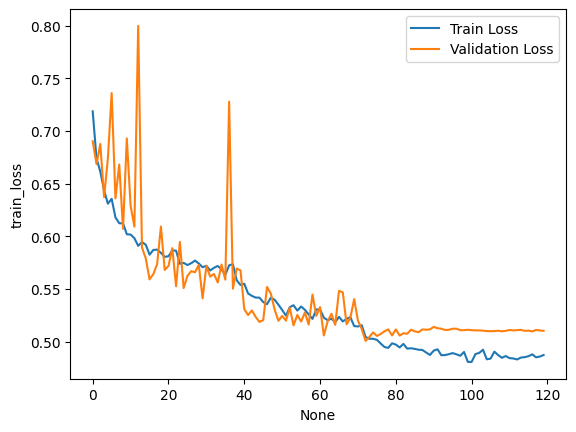

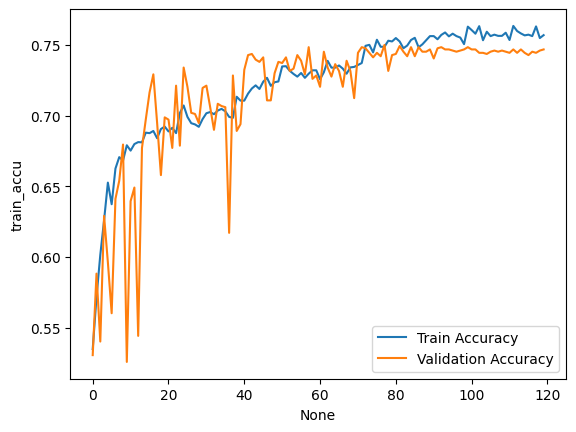

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot the training and validation losses
train_perf = pd.DataFrame({'train_loss': train_loss, 'val_loss': val_loss})
sns.lineplot(data=train_perf, y='train_loss', x=train_perf.index, label='Train Loss')
sns.lineplot(data=train_perf, y='val_loss', x=train_perf.index, label='Validation Loss')
plt.show()

# Plot the training and validation accuracies
plt.figure()
train_perf = pd.DataFrame({'train_accu': train_accu, 'val_accu': val_accu})
sns.lineplot(data=train_perf, y='train_accu', x=train_perf.index, label='Train Accuracy')
sns.lineplot(data=train_perf, y='val_accu', x=train_perf.index, label='Validation Accuracy')
plt.show()

Test Accuracy: 0.7213771016813451


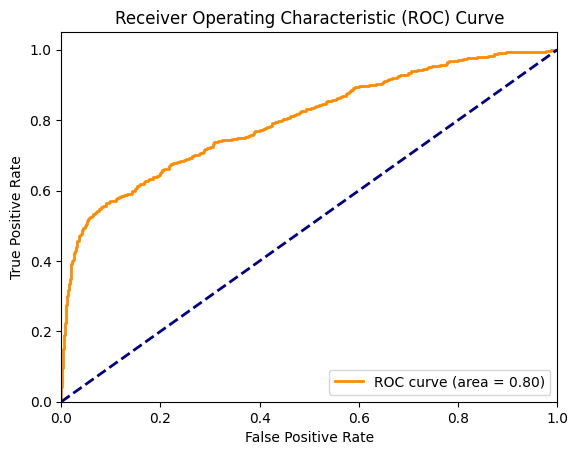

In [61]:
# predict on test set
test_pred, test_target, test_image = test(model, test_loader)
print(f"Test Accuracy: {calc_accuracy(test_pred, test_target)}")

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_target, test_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

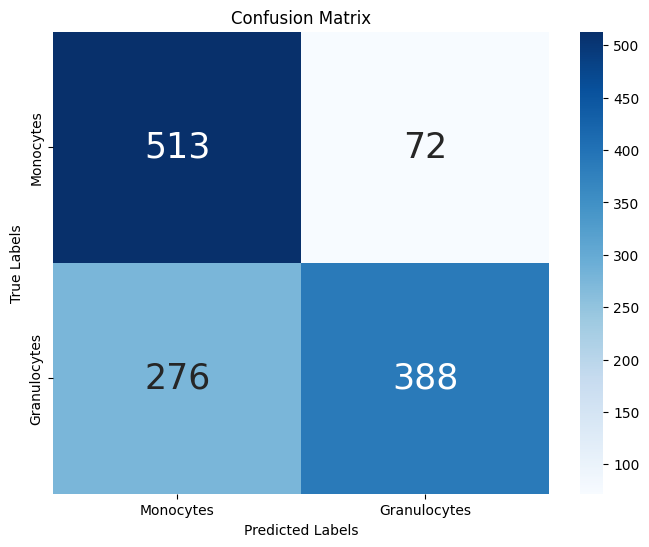

In [64]:
from sklearn.metrics import confusion_matrix

pred_labels = (test_pred >= 0.5).astype(int)  # Convert probabilities to 0 or 1 based on threshold

# Calculate the confusion matrix
cm = confusion_matrix(test_target, pred_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', annot_kws={"size": 25}, xticklabels=['Monocytes', 'Granulocytes'], yticklabels=['Monocytes', 'Granulocytes'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [54]:
import random

def visualize_image_gallery(images, rows, cols):
    
    if len(images) < rows * cols:
        empty_images = np.repeat(np.zeros_like(images[0])[np.newaxis,...], len(images - rows * cols), axis=0)
        images = np.concatenate((images, empty_images), axis=0)
        
    elif len(images) > rows * cols:
        images = images[random.sample(range(len(images)), rows * cols)]

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    fig.subplots_adjust(wspace=1, hspace=1)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

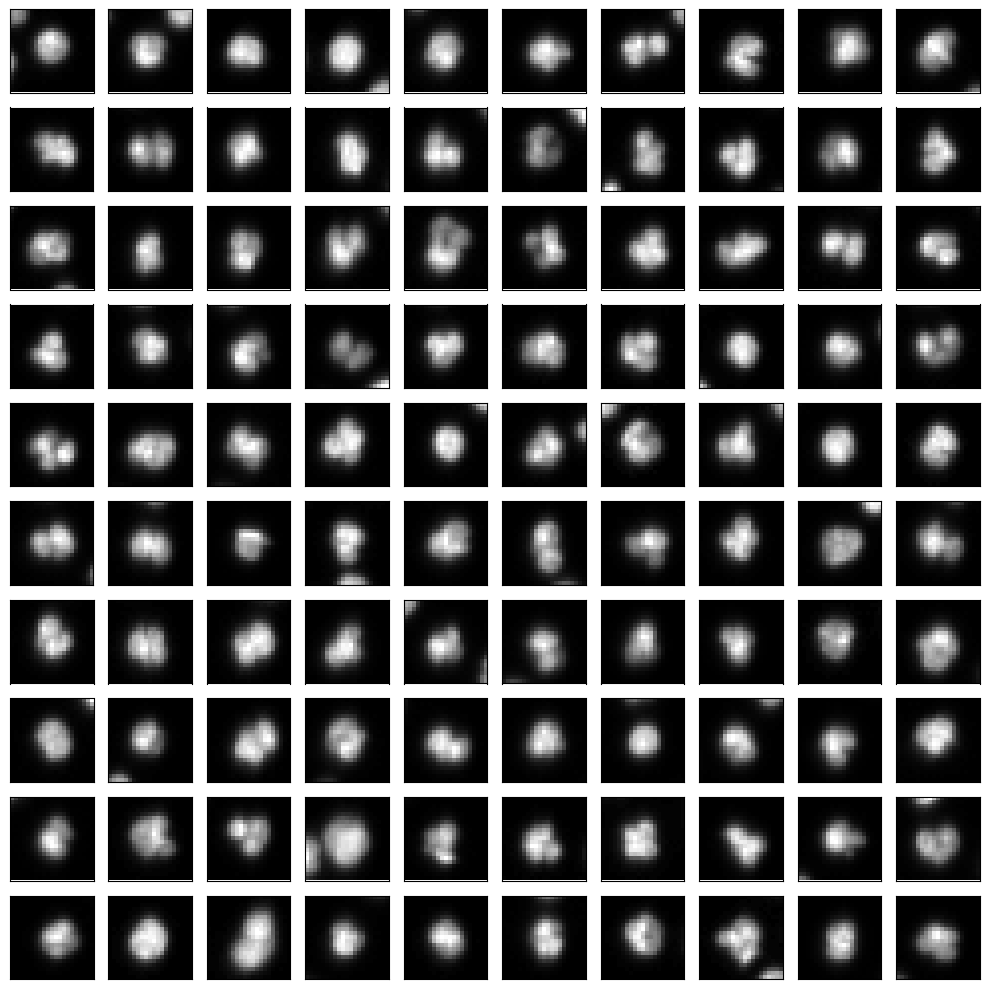

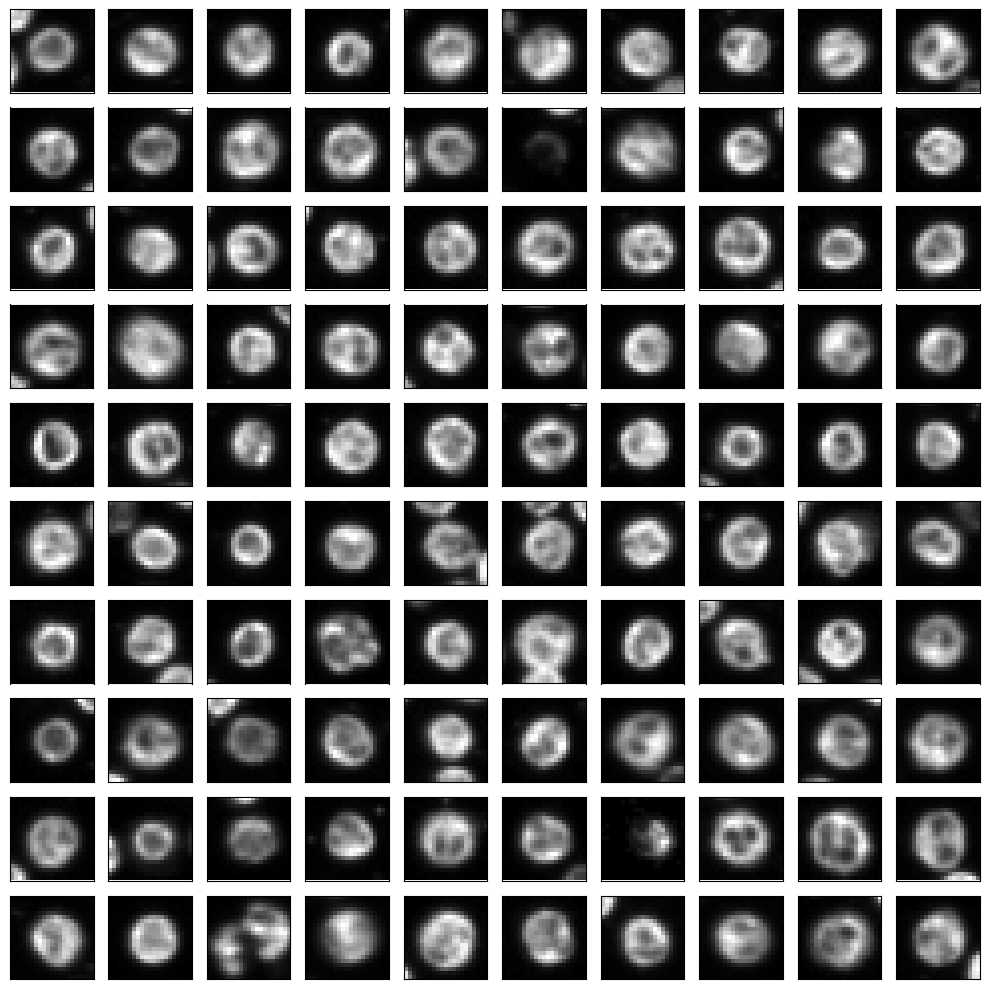

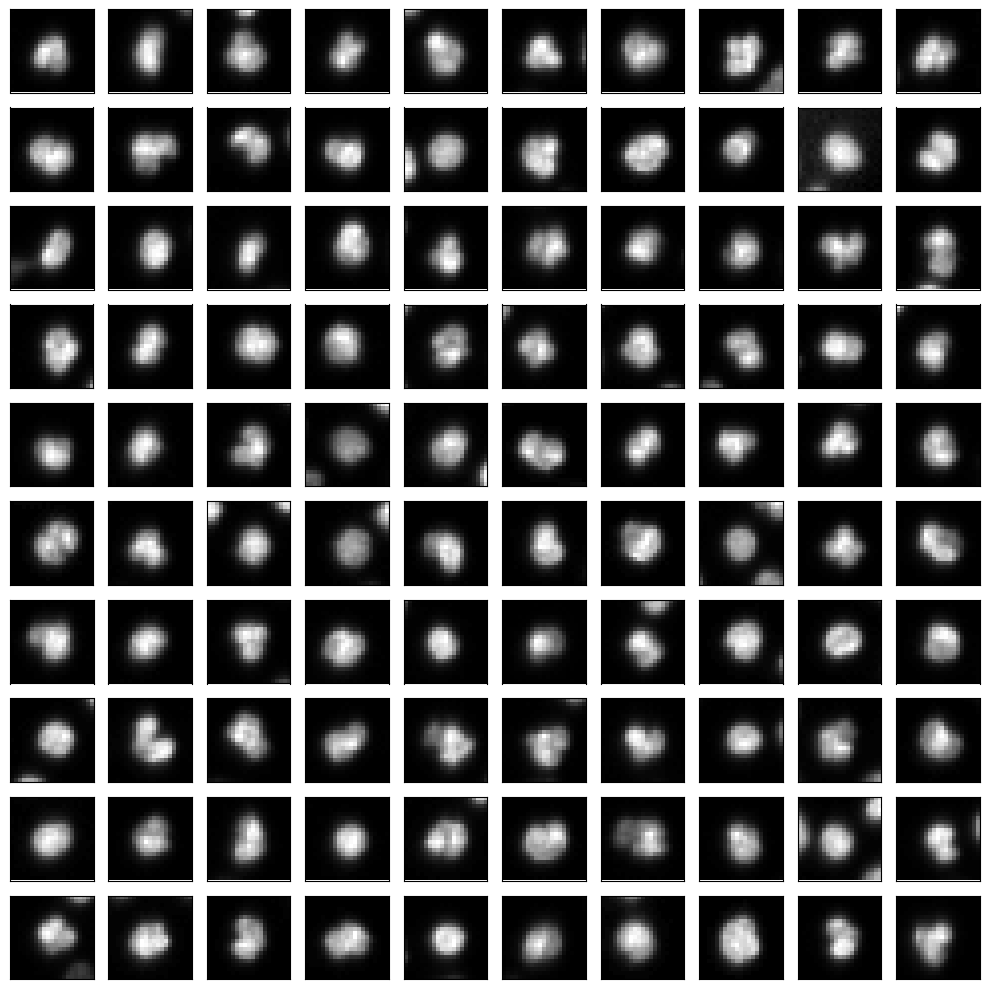

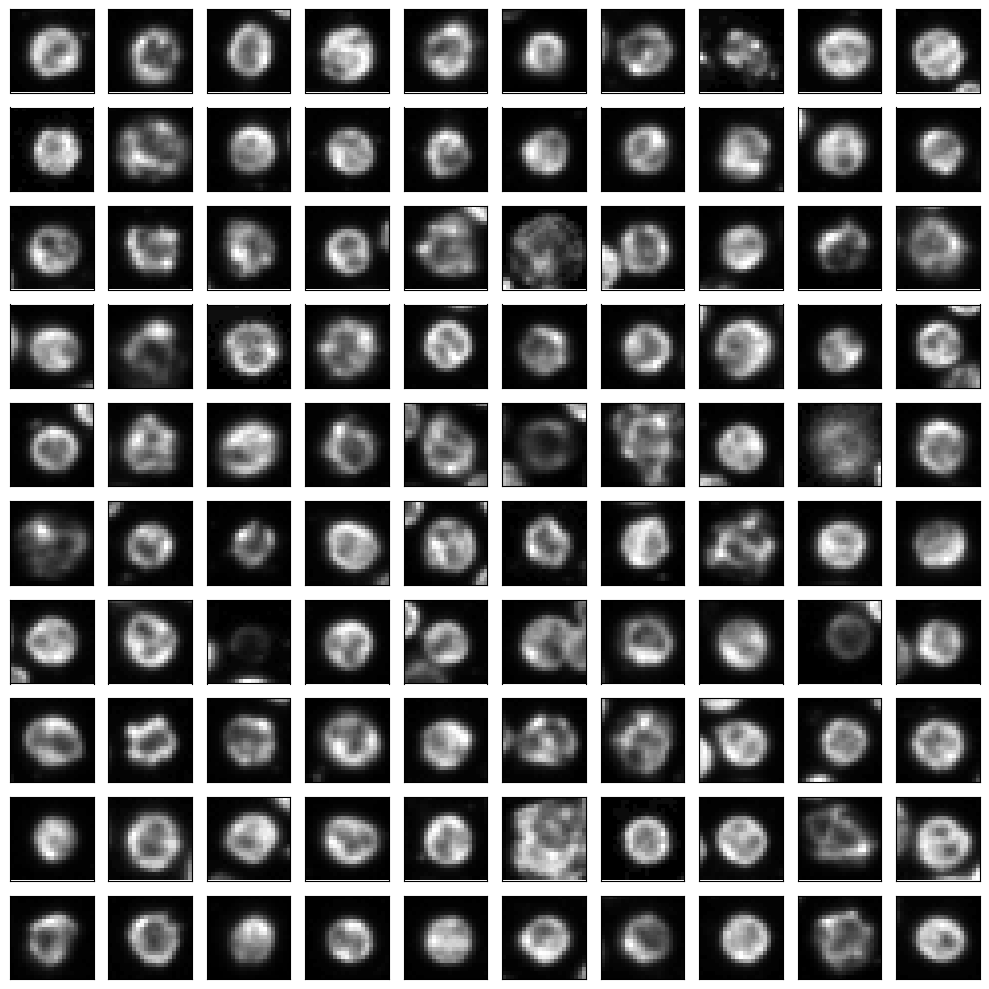

In [63]:
# Visualize the first 25 images in the test set
# lymph_index = np.where(test_target == 1)[0]
# visualize_image_gallery(test_image[lymph_index, 0, :, :], 10, 10)
# visualize_image_gallery(test_image[lymph_index, 1, :, :], 10, 10)

granulocytes_index = np.where(test_target == 0)[0]
visualize_image_gallery(test_image[granulocytes_index, 0, :, :], 10, 10)
visualize_image_gallery(test_image[granulocytes_index, 1, :, :], 10, 10)

monocytes_index = np.where(test_target == 1)[0]
visualize_image_gallery(test_image[monocytes_index, 0, :, :], 10, 10)
visualize_image_gallery(test_image[monocytes_index, 1, :, :], 10, 10)

In [56]:
torch.save(model.state_dict(), '0ADD710_myelo_classifier.pth')

In [57]:
# comments
# class HDF5Dataset(Dataset):
#     def __init__(self, file_path, transform=None):
#         self.file_path = file_path
#         self.transform = transform
        
#         # Open the HDF5 file
#         with h5py.File(file_path, 'r') as file:
#             self.images = file['images'][:]
            
#         self.images = self.images[:, 1:, 1:, :] / 65535.0
#         self.targets = pd.read_hdf(file_path, key='features',
#                                    mode='r')['target'].values

#         # Get the number of samples in the dataset
#         self.num_samples = len(self.targets)

#     def __getitem__(self, index):
#         # Get the image and target from the HDF5 file
#         image = self.images[index]
#         target = self.targets[index]

#         # Convert the image and target to PyTorch tensors
#         image = torch.from_numpy(image).float()
#         target = torch.from_numpy(target).float()

#         # Apply any data augmentations or transformations
#         if self.transform is not None:
#             image = self.transform(image)

#         return image, target

#     def __len__(self):
#         return self.num_samples